In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [4]:
FILE_PATH = "Dataset\EURUSD\EURUSD_M30_with_features.csv"

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\Stephen\AppData\Local\Temp\ipykernel_23256\891419644.py:1: SyntaxWarning: invalid escape sequence '\E'
  FILE_PATH = "Dataset\EURUSD\EURUSD_M30_with_features.csv"


In [5]:
# Load the dataset with features
data = pd.read_csv(FILE_PATH)

# Ensure DateTime is parsed correctly
data['DateTime'] = pd.to_datetime(data['DateTime'])

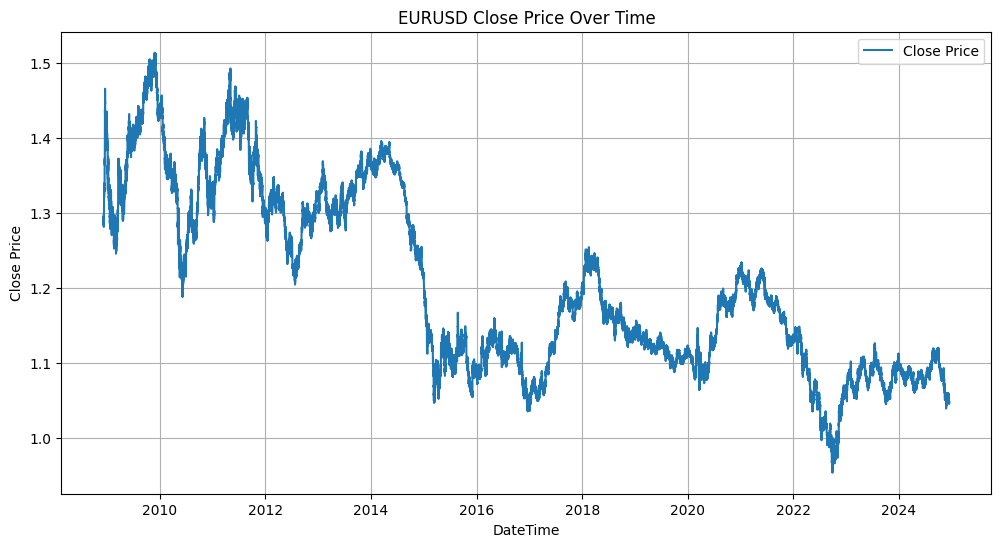

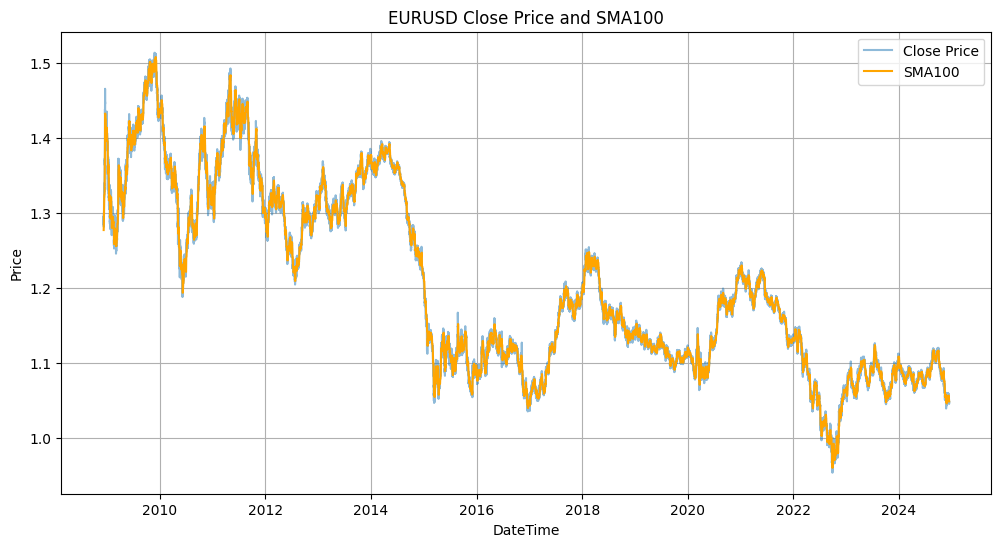

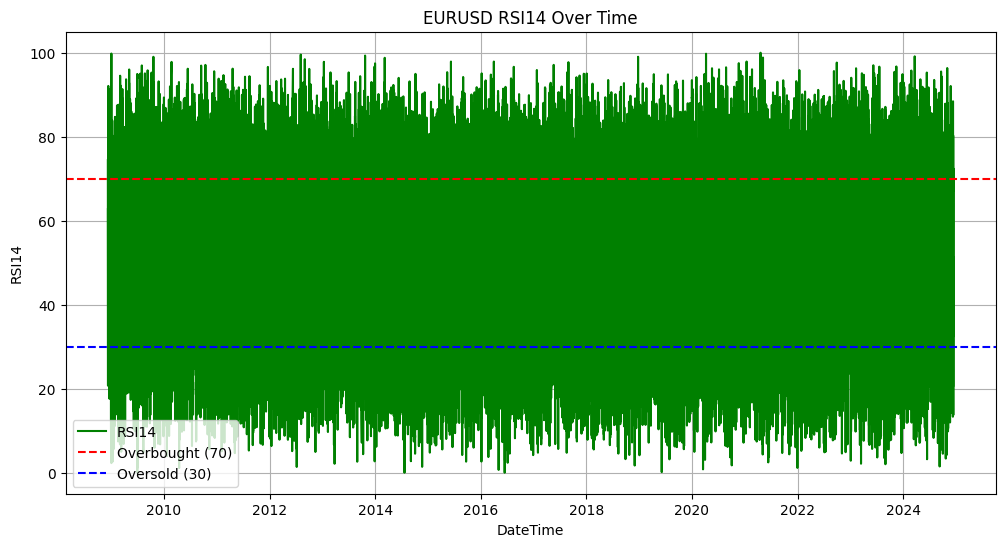

In [6]:
# Plot Close Price
plt.figure(figsize=(12, 6))
plt.plot(data['DateTime'], data['Close'], label='Close Price')
plt.title('EURUSD Close Price Over Time')
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot SMA100
plt.figure(figsize=(12, 6))
plt.plot(data['DateTime'], data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['DateTime'], data['SMA100'], label='SMA100', color='orange')
plt.title('EURUSD Close Price and SMA100')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot RSI14
plt.figure(figsize=(12, 6))
plt.plot(data['DateTime'], data['RSI14'], label='RSI14', color='green')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
plt.title('EURUSD RSI14 Over Time')
plt.xlabel('DateTime')
plt.ylabel('RSI14')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Select features for training (e.g., SMA100, RSI14, Close)
features = ['SMA100', 'RSI14', 'Close']
X = data[features].values

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to('cuda')

In [7]:
def generate_pseudo_labels(X_scaled, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pseudo_labels = kmeans.fit_predict(X_scaled)
    return torch.tensor(pseudo_labels, dtype=torch.long).to('cuda')

pseudo_labels = generate_pseudo_labels(X_scaled)

In [9]:
class ForexModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ForexModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 8)
        self.fc5 = nn.Linear(8, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.softmax(self.fc5(x), dim=1)
        return x

In [10]:
# Initialize model, loss, and optimizer
model = ForexModel(input_dim=X_tensor.shape[1], output_dim=4).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train_model(model, X_tensor, pseudo_labels, epochs=50, batch_size=64):
    dataset = torch.utils.data.TensorDataset(X_tensor, pseudo_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

train_model(model, X_tensor, pseudo_labels)

Epoch 1/50, Loss: 2612.9481
Epoch 2/50, Loss: 2418.6060
Epoch 3/50, Loss: 2398.4370
Epoch 4/50, Loss: 2399.0814
Epoch 5/50, Loss: 2399.4100
Epoch 6/50, Loss: 2397.2110
Epoch 7/50, Loss: 2396.4889
Epoch 8/50, Loss: 2398.3945
Epoch 9/50, Loss: 2401.8010
Epoch 10/50, Loss: 2403.4654
Epoch 11/50, Loss: 2399.8079
Epoch 12/50, Loss: 2397.9205
Epoch 13/50, Loss: 2400.6359
Epoch 14/50, Loss: 2400.2577
Epoch 15/50, Loss: 2397.9470
Epoch 16/50, Loss: 2398.5157
Epoch 17/50, Loss: 2399.4738
Epoch 18/50, Loss: 2400.2021
Epoch 19/50, Loss: 2392.1562
Epoch 20/50, Loss: 2396.1676
Epoch 21/50, Loss: 2400.9297
Epoch 22/50, Loss: 2396.2898
Epoch 23/50, Loss: 2395.6505
Epoch 24/50, Loss: 2393.8211
Epoch 25/50, Loss: 2396.8514
Epoch 26/50, Loss: 2396.1483
Epoch 27/50, Loss: 2396.8481
Epoch 28/50, Loss: 2401.4379
Epoch 29/50, Loss: 2398.4829
Epoch 30/50, Loss: 2397.6853
Epoch 31/50, Loss: 2398.7868
Epoch 32/50, Loss: 2398.4890
Epoch 33/50, Loss: 2393.2060
Epoch 34/50, Loss: 2399.9265
Epoch 35/50, Loss: 2393

In [12]:
def calculate_target_stop_prices(close_price, condition):
    if condition == 0:  # Buy
        target_price = close_price * 1.02  # 2% increase
        stop_loss_price = close_price * 0.98  # 2% decrease
    elif condition == 1:  # Sell
        target_price = close_price * 0.98  # 2% decrease
        stop_loss_price = close_price * 1.02  # 2% increase
    else:  # Hold or Nothing
        target_price = stop_loss_price = close_price
    return target_price, stop_loss_price

In [13]:
# Example usage
example_data = X_tensor[:10]
model.eval()
with torch.no_grad():
    predictions = model(example_data)
conditions = torch.argmax(predictions, axis=1).cpu().numpy()
for i, condition in enumerate(conditions):
    close_price = data.iloc[i]['Close']
    target, stop_loss = calculate_target_stop_prices(close_price, condition)
    print(f"Condition: {condition}, Target Price: {target:.4f}, Stop Loss Price: {stop_loss:.4f}")


Condition: 0, Target Price: 1.3175, Stop Loss Price: 1.2658
Condition: 0, Target Price: 1.3165, Stop Loss Price: 1.2648
Condition: 0, Target Price: 1.3173, Stop Loss Price: 1.2656
Condition: 0, Target Price: 1.3188, Stop Loss Price: 1.2671
Condition: 0, Target Price: 1.3212, Stop Loss Price: 1.2694
Condition: 0, Target Price: 1.3199, Stop Loss Price: 1.2682
Condition: 0, Target Price: 1.3199, Stop Loss Price: 1.2682
Condition: 0, Target Price: 1.3205, Stop Loss Price: 1.2687
Condition: 0, Target Price: 1.3221, Stop Loss Price: 1.2702
Condition: 0, Target Price: 1.3203, Stop Loss Price: 1.2685
